In [1]:
!pip install pandas numpy requests beautifulsoup4 textblob scikit-learn nltk joblib matplotlib wordcloud
!python -m textblob.download_corpora


Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\capat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\capat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\capat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\capat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\capat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\conll2000.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\capat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.


In [2]:
import os

# Define project structure
folders = ["data", "models", "figures"]
files = ["Sentiment_Analysis.ipynb", "requirements.txt"]

# Create main folder
project_path = r"C:\SentimentProject"
os.makedirs(project_path, exist_ok=True)

# Create subfolders
for folder in folders:
    os.makedirs(os.path.join(project_path, folder), exist_ok=True)

# Create empty files
for file in files:
    open(os.path.join(project_path, file), 'a').close()

print("Project structure created successfully!")


Project structure created successfully!


In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

# make sure the folder exists
os.makedirs("data", exist_ok=True)

# scrape
url = "https://news.ycombinator.com/"
r = requests.get(url, timeout=10)
soup = BeautifulSoup(r.text, "html.parser")

titles = [item.get_text(strip=True) for item in soup.select(".titleline")]

# create dataframe
df = pd.DataFrame({"text": titles})

# ✅ correct save line
df.to_csv("data/IMDB_Dataset.csv", index=False, encoding="utf-8")

df.head()



,text
0,Pebble Watch software is now 100% open source(...
1,Unpowered SSDs slowly lose data(xda-developers...
2,Claude Advanced Tool Use(anthropic.com)
3,Cool-retro-term: terminal emulator which mimic...
4,Show HN: I built an interactive HN Simulator(y...


In [4]:
import re

def clean_text(s):
    s = str(s)
    s = re.sub(r'http\S+|www\S+', '', s)
    s = re.sub(r'[^A-Za-z0-9\s\.\,]', '', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['text_clean'] = df['text'].apply(clean_text)
df.to_csv("data/IMDB_Dataset.csv", index=False, encoding="utf-8")
df.head()


,text,text_clean
0,Pebble Watch software is now 100% open source(...,Pebble Watch software is now 100 open sourceer...
1,Unpowered SSDs slowly lose data(xda-developers...,Unpowered SSDs slowly lose dataxdadevelopers.com
2,Claude Advanced Tool Use(anthropic.com),Claude Advanced Tool Useanthropic.com
3,Cool-retro-term: terminal emulator which mimic...,Coolretroterm terminal emulator which mimics l...
4,Show HN: I built an interactive HN Simulator(y...,Show HN I built an interactive HN Simulatorysi...


In [5]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['polarity'] = df['text_clean'].apply(get_sentiment)
df['label'] = df['polarity'].apply(lambda x: 'positive' if x>0 else ('negative' if x<0 else 'neutral'))
df.to_csv("data/sentiment_text.csv", index=False, encoding="utf-8")
df.head(10)



,text,text_clean,polarity,label
0,Pebble Watch software is now 100% open source(...,Pebble Watch software is now 100 open sourceer...,0.0,neutral
1,Unpowered SSDs slowly lose data(xda-developers...,Unpowered SSDs slowly lose dataxdadevelopers.com,-0.3,negative
2,Claude Advanced Tool Use(anthropic.com),Claude Advanced Tool Useanthropic.com,0.4,positive
3,Cool-retro-term: terminal emulator which mimic...,Coolretroterm terminal emulator which mimics l...,0.0,neutral
4,Show HN: I built an interactive HN Simulator(y...,Show HN I built an interactive HN Simulatorysi...,0.0,neutral
5,Claude Opus 4.5(anthropic.com),Claude Opus 4.5anthropic.com,0.0,neutral
6,Build a Compiler in Five Projects(kmicinski.com),Build a Compiler in Five Projectskmicinski.com,0.0,neutral
7,Three Years from GPT-3 to Gemini 3(oneusefulth...,Three Years from GPT3 to Gemini 3oneusefulthin...,0.0,neutral
8,Random lasers from peanut kernel doped with bi...,Random lasers from peanut kernel doped with bi...,-0.5,negative
9,Show HN: OCR Arena – A playground for OCR mode...,Show HN OCR Arena A playground for OCR modelso...,0.0,neutral


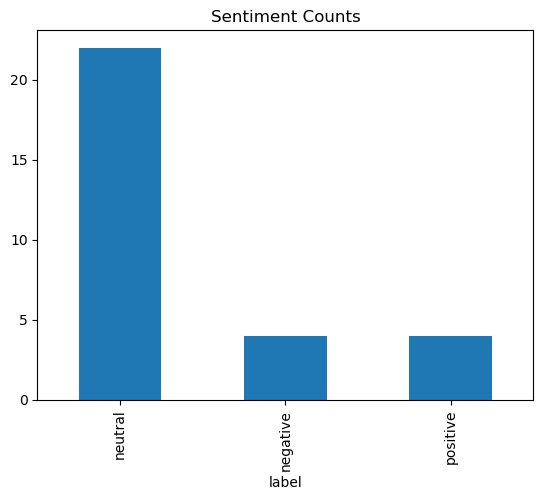

In [6]:
df['label'].value_counts().plot(kind='bar', title='Sentiment Counts');


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

df_model = df[df['label'] != 'neutral']
X = df_model['text_clean']
y = df_model['label'].map({'positive':1, 'negative':0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)
pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))



Accuracy: 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



In [8]:
import os
import joblib

# Create folder if it doesn't exist
os.makedirs("models", exist_ok=True)

df.to_csv("data/final_sentiment.csv", index=False)

joblib.dump(model, "models/sentiment_model.pkl")
joblib.dump(vec, "models/tfidf.pkl")


['models/tfidf.pkl']

In [9]:
import joblib

df.to_csv("data/final_sentiment.csv", index=False)
joblib.dump(model, "models/sentiment_model.pkl")
joblib.dump(vec, "models/tfidf.pkl")



['models/tfidf.pkl']

In [10]:
pip install azure-storage-blob


Note: you may need to restart the kernel to use updated packages.


In [11]:
import os

# create a "data" folder beside your notebook if it doesn't exist
os.makedirs("data", exist_ok=True)

print("Current folder:", os.getcwd())
print("Contents:", os.listdir())


Current folder: C:\Users\capat\AIDI\assignments\Sem-2\AI infrastructure\Sentiment analysis
Contents: ['.ipynb_checkpoints', '1.docx', 'data', 'models', 'Presentation - End-to-End Sentiment Analysis (1).pdf', 'Presentation - End-to-End Sentiment Analysis (1).pptx', 'scrapedData.csv', 'sentiment-analysis (1).pdf', 'sentimentanalysis (3).ipynb', 'Untitled.ipynb', '~$Presentation - End-to-End Sentiment Analysis (1).pptx']


In [12]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

os.makedirs("data", exist_ok=True)

# 1) Scrape headlines from Hacker News
url = "https://news.ycombinator.com/"
r = requests.get(url, timeout=10)
soup = BeautifulSoup(r.text, "html.parser")

titles = [item.get_text(strip=True) for item in soup.select(".titleline")]

# 2) Put into a DataFrame
df = pd.DataFrame({"text": titles})

# 3) Save FIRST VERSION of the csv
df.to_csv("data/news_raw.csv", index=False, encoding="utf-8")

df.head()


,text
0,Pebble Watch software is now 100% open source(...
1,Unpowered SSDs slowly lose data(xda-developers...
2,Claude Advanced Tool Use(anthropic.com)
3,Cool-retro-term: terminal emulator which mimic...
4,Show HN: I built an interactive HN Simulator(y...


In [13]:
import os
print(os.listdir("data"))

['final_sentiment.csv', 'IMDB_Dataset.csv', 'news_raw.csv', 'sentiment_text.csv']


In [14]:
import re
from textblob import TextBlob
import numpy as np

# Clean text a bit
def clean_text(s):
    s = str(s)
    s = re.sub(r'http\S+|www\S+', '', s)          # remove links
    s = re.sub(r'[^A-Za-z0-9\s\.\,]', '', s)     # keep basic chars
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df["text_clean"] = df["text"].apply(clean_text)

# Sentiment score using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity   # between -1 (neg) and +1 (pos)

df["sentiment_score"] = df["text_clean"].apply(get_sentiment)

# Label as positive / negative / neutral
df["sentiment_label"] = np.where(
    df["sentiment_score"] > 0.1, "positive",
    np.where(df["sentiment_score"] < -0.1, "negative", "neutral")
)

# Save FINAL CSV
df.to_csv("data/final_sentiment.csv", index=False, encoding="utf-8")

df.head()


,text,text_clean,sentiment_score,sentiment_label
0,Pebble Watch software is now 100% open source(...,Pebble Watch software is now 100 open sourceer...,0.0,neutral
1,Unpowered SSDs slowly lose data(xda-developers...,Unpowered SSDs slowly lose dataxdadevelopers.com,-0.3,negative
2,Claude Advanced Tool Use(anthropic.com),Claude Advanced Tool Useanthropic.com,0.4,positive
3,Cool-retro-term: terminal emulator which mimic...,Coolretroterm terminal emulator which mimics l...,0.0,neutral
4,Show HN: I built an interactive HN Simulator(y...,Show HN I built an interactive HN Simulatorysi...,0.0,neutral


In [15]:
print(os.listdir("data"))
      

['final_sentiment.csv', 'IMDB_Dataset.csv', 'news_raw.csv', 'sentiment_text.csv']


In [16]:
sent_df = pd.read_csv("data/final_sentiment.csv")
sent_df.head()


,text,text_clean,sentiment_score,sentiment_label
0,Pebble Watch software is now 100% open source(...,Pebble Watch software is now 100 open sourceer...,0.0,neutral
1,Unpowered SSDs slowly lose data(xda-developers...,Unpowered SSDs slowly lose dataxdadevelopers.com,-0.3,negative
2,Claude Advanced Tool Use(anthropic.com),Claude Advanced Tool Useanthropic.com,0.4,positive
3,Cool-retro-term: terminal emulator which mimic...,Coolretroterm terminal emulator which mimics l...,0.0,neutral
4,Show HN: I built an interactive HN Simulator(y...,Show HN I built an interactive HN Simulatorysi...,0.0,neutral


In [17]:
import os
os.getcwd(), os.listdir(), os.listdir("data")


('C:\\Users\\capat\\AIDI\\assignments\\Sem-2\\AI infrastructure\\Sentiment analysis',
 ['.ipynb_checkpoints',
  '1.docx',
  'data',
  'models',
  'Presentation - End-to-End Sentiment Analysis (1).pdf',
  'Presentation - End-to-End Sentiment Analysis (1).pptx',
  'scrapedData.csv',
  'sentiment-analysis (1).pdf',
  'sentimentanalysis (3).ipynb',
  'Untitled.ipynb',
  '~$Presentation - End-to-End Sentiment Analysis (1).pptx'],
 ['final_sentiment.csv',
  'IMDB_Dataset.csv',
  'news_raw.csv',
  'sentiment_text.csv'])